# Likelihood Ratio Outlier Detection with PixelCNN++

## Method

The outlier detector described by [Ren et al. (2019)](https://arxiv.org/abs/1906.02845) in [Likelihood Ratios for Out-of-Distribution Detection](https://arxiv.org/abs/1906.02845) uses the likelihood ratio between 2 generative models as the outlier score. One model is trained on the original data while the other is trained on a perturbed version of the dataset. This is based on the observation that the likelihood score for an instance under a generative model can be heavily affected by population level background statistics. The second generative model is therefore trained to capture the background statistics still present in the perturbed data while the semantic features have been erased by the perturbations.

The perturbations are added using an independent and identical Bernoulli distribution with rate $\mu$ which substitutes a feature with one of the other possible feature values with equal probability. For images, this means changing a pixel with a different pixel randomly sampled within the $0$ to $255$ pixel range.

The generative model used in the example is a [PixelCNN++](https://arxiv.org/abs/1701.05517), adapted from the official TensorFlow Probability [implementation](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/PixelCNN), and available as a standalone model in `from alibi_detect.models.tensorflow import PixelCNN`.


## Dataset

The training set [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) consists of 60,000 28 by 28 grayscale images distributed over 10 classes. The classes represent items of clothing such as shirts or trousers. At test time, we want to distinguish the Fashion-MNIST test set from MNIST, which represents 28 by 28 grayscale numbers from 0 to 9.

This notebook requires the `seaborn` package for visualization which can be installed via `pip`:

In [ ]:
!pip install seaborn

In [1]:
import os
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import tensorflow as tf

from alibi_detect.od import LLR
from alibi_detect.models.tensorflow import PixelCNN
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.saving import save_detector, load_detector
from alibi_detect.utils.tensorflow import predict_batch
from alibi_detect.utils.visualize import plot_roc

### Utility Functions

In [2]:
def load_data(dataset: str) -> tuple:
    if dataset == 'mnist':
        (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    elif dataset == 'fashion_mnist':
        (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    else:
        raise NotImplementedError
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    y_train = y_train.astype('int64').reshape(-1,)
    y_test = y_test.astype('int64').reshape(-1,)
    if len(X_train.shape) == 3:
        shape = (-1,) + X_train.shape[1:] + (1,)
        X_train = X_train.reshape(shape)
        X_test = X_test.reshape(shape)
    return (X_train, y_train), (X_test, y_test)


def plot_grid_img(X: np.ndarray, figsize: tuple = (10, 6)) -> None:
    n = X.shape[0]
    nrows = int(n**.5)
    ncols = int(np.ceil(n / nrows))
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    n_subplot = 1
    for r in range(nrows):
        for c in range(ncols):
            plt.subplot(nrows, ncols, n_subplot)
            plt.axis('off')
            plt.imshow(X[n_subplot-1, :, :, 0])
            n_subplot += 1
            

def plot_grid_logp(idx: list, X: np.ndarray, logp_s: np.ndarray, 
                   logp_b: np.ndarray, figsize: tuple = (10, 6)) -> None:
    nrows, ncols = len(idx), 4
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    n_subplot = 1
    for r in range(nrows):
        plt.subplot(nrows, ncols, n_subplot)
        plt.imshow(X[idx[r], :, :, 0])
        plt.colorbar()
        plt.axis('off')
        if r == 0:
            plt.title('Image')
        n_subplot += 1

        plt.subplot(nrows, ncols, n_subplot)
        plt.imshow(logp_s[idx[r], :, :])
        plt.colorbar()
        plt.axis('off')
        if r == 0:
            plt.title('Semantic Logp')
        n_subplot += 1

        plt.subplot(nrows, ncols, n_subplot)
        plt.imshow(logp_b[idx[r], :, :])
        plt.colorbar()
        plt.axis('off')
        if r == 0:
            plt.title('Background Logp')
        n_subplot += 1

        plt.subplot(nrows, ncols, n_subplot)
        plt.imshow(logp_s[idx[r], :, :] - logp_b[idx[r], :, :])
        plt.colorbar()
        plt.axis('off')
        if r == 0:
            plt.title('LLR')
        n_subplot += 1

### Load data

The in-distribution dataset is Fashion-MNIST and the out-of-distribution dataset we'd like to detect is MNIST.

In [3]:
(X_train_in, y_train_in), (X_test_in, y_test_in) = load_data('fashion_mnist')
X_test_ood, y_test_ood = load_data('mnist')[1]
input_shape = X_train_in.shape[1:]
print(X_train_in.shape, X_test_in.shape, X_test_ood.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1) (10000, 28, 28, 1)


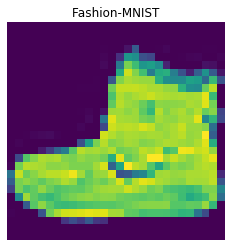

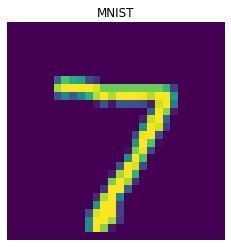

In [4]:
i = 0
plt.imshow(X_train_in[i].reshape(input_shape[:-1]))
plt.title('Fashion-MNIST')
plt.axis('off')
plt.show();
plt.imshow(X_test_ood[i].reshape(input_shape[:-1]))
plt.title('MNIST')
plt.axis('off')
plt.show();

### Define PixelCNN++ model

We now need to define our generative model. This is not necessary if the pretrained detector is later loaded from the Google Bucket.

Key PixelCNN++ arguments in a nutshell:

* *num_resnet*: number of layers ([Fig.2 PixelCNN](https://arxiv.org/abs/1606.05328)) within each hierarchical block ([Fig.2 PixelCNN++](https://arxiv.org/abs/1701.05517)).

* *num_hierarchies*: number of blocks separated by expansions or contractions of dimensions. See [Fig.2 PixelCNN++](https://arxiv.org/abs/1701.05517).

* *num_filters*: number of convolutional filters.

* *num_logistic_mix*: number of components in the logistic mixture distribution.

* *receptive_field_dims*: height and width in pixels of the receptive field above and to the left of a given pixel.

Optionally, a different model can be passed to the detector with argument *model_background*. The [Likelihood Ratio paper](https://arxiv.org/abs/1906.02845) mentions that additional $L2$-regularization (*l2_weight*) for the background model could improve detection performance.

In [5]:
model = PixelCNN(
    image_shape=input_shape,
    num_resnet=5,
    num_hierarchies=2,
    num_filters=32,
    num_logistic_mix=1,
    receptive_field_dims=(3, 3),
    dropout_p=.3,
    l2_weight=0.
)

### Load or train the outlier detector

We can again either fetch the pretrained detector from a [Google Cloud Bucket](https://console.cloud.google.com/storage/browser/seldon-models/alibi-detect/od/LLR/fashion_mnist) or train one from scratch:

In [6]:
load_pretrained = True

In [7]:
filepath = os.path.join(os.getcwd(), 'my_path')  # change to download directory
detector_type = 'outlier'
dataset = 'fashion_mnist'
detector_name = 'LLR'
filepath = os.path.join(filepath, detector_name)    
if load_pretrained:  # load pretrained outlier detector
    od = fetch_detector(filepath, detector_type, dataset, detector_name)
else:
    # initialize detector
    od = LLR(threshold=None, model=model)
    
    # train
    od.fit(
        X_train_in,
        mutate_fn_kwargs=dict(rate=.2),
        mutate_batch_size=1000,
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        epochs=20,
        batch_size=32,
        verbose=False
    )
    
    # save the trained outlier detector
    save_detector(od, filepath)

We can load our saved detector again by defining the PixelCNN architectures for the semantic and background models as well as providing the shape of the input data:

In [8]:
kwargs = {'dist_s': model, 'dist_b': model.copy(), 'input_shape': input_shape}
od = load_detector(filepath, **kwargs)

Let's sample some instances from the semantic model to check how good our generative model is:

In [9]:
n_sample = 16
X_sample = od.dist_s.sample(n_sample).numpy()

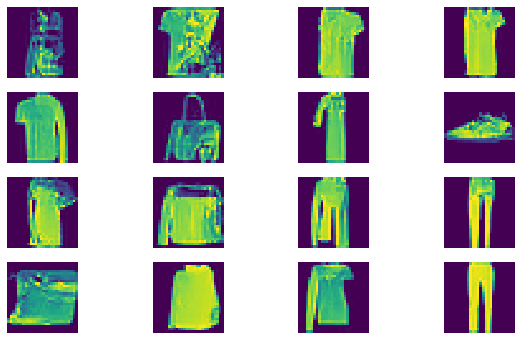

In [10]:
plot_grid_img(X_sample)

Most of the instances look like they represent the dataset well. When we do the same thing for our background model, we see that there is some background noise injected:

In [11]:
X_sample = od.dist_b.sample(n_sample).numpy()

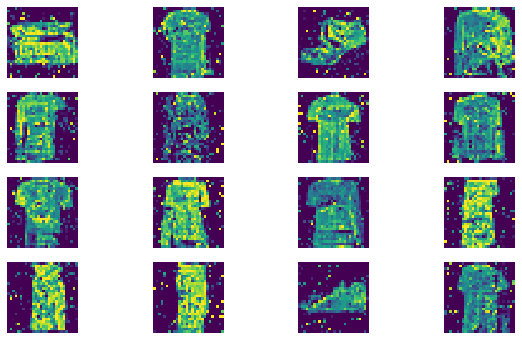

In [12]:
plot_grid_img(X_sample)

### Compare the log likelihoods

Let's compare the log likelihoods of the inliers vs. the outlier data under the semantic and background models. Although MNIST data looks very distinct from Fashion-MNIST, the generative model does not distinguish well between the 2 datasets as shown by the histograms of the log likelihoods:

In [13]:
shape_in, shape_ood = X_test_in.shape[0], X_test_ood.shape[0]

In [14]:
# semantic model
logp_s_in = predict_batch(X_test_in, od.dist_s.log_prob, batch_size=32, shape=shape_in)
logp_s_ood = predict_batch(X_test_ood, od.dist_s.log_prob, batch_size=32, shape=shape_ood)
logp_s = np.concatenate([logp_s_in, logp_s_ood])
# background model
logp_b_in = predict_batch(X_test_in, od.dist_b.log_prob, batch_size=32, shape=shape_in)
logp_b_ood = predict_batch(X_test_ood, od.dist_b.log_prob, batch_size=32, shape=shape_ood)

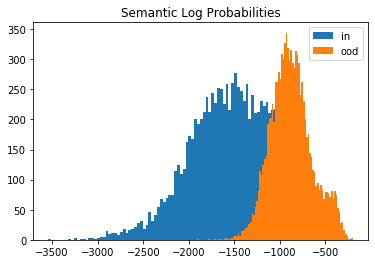

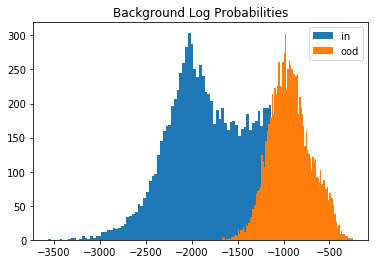

In [15]:
# show histograms
plt.hist(logp_s_in, bins=100, label='in');
plt.hist(logp_s_ood, bins=100, label='ood');
plt.title('Semantic Log Probabilities')
plt.legend()
plt.show()

plt.hist(logp_b_in, bins=100, label='in');
plt.hist(logp_b_ood, bins=100, label='ood');
plt.title('Background Log Probabilities')
plt.legend()
plt.show()

This is due to the dominance of the background which is similar (basically lots of $0$'s for both datasets). If we however take the likelihood ratio, the MNIST data are detected as outliers. And this is exactly what the outlier detector does as well:

In [16]:
llr_in = logp_s_in - logp_b_in
llr_ood = logp_s_ood - logp_b_ood

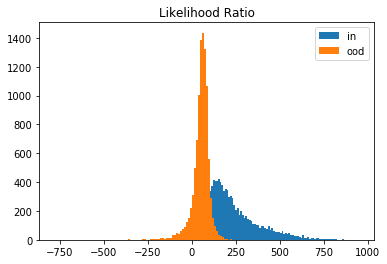

In [17]:
plt.hist(llr_in, bins=100, label='in');
plt.hist(llr_ood, bins=100, label='ood');
plt.title('Likelihood Ratio')
plt.legend()
plt.show()

### Detect outliers

We follow the same procedure with the outlier detector. First we need to set an outlier threshold with `infer_threshold`. We need to pass a batch of instances and specify what percentage of those we consider to be normal via `threshold_perc`. Let's assume we have a small batch of data with roughly $50$% outliers but we don't know exactly which ones.

In [18]:
n, frac_outlier = 500, .5
perc_outlier = 100 * frac_outlier
n_in, n_ood = int(n * (1 - frac_outlier)), int(n * frac_outlier)
idx_in = np.random.choice(shape_in, size=n_in, replace=False)
idx_ood = np.random.choice(shape_ood, size=n_ood, replace=False)
X_threshold = np.concatenate([X_test_in[idx_in], X_test_ood[idx_ood]])

In [19]:
od.infer_threshold(X_threshold, threshold_perc=perc_outlier, batch_size=32)
print('New threshold: {}'.format(od.threshold))

New threshold: -96.67073059082031


Let's save the outlier detector with updated threshold:

In [20]:
save_detector(od, filepath)

Let's now predict outliers on the combined Fashion-MNIST and MNIST datasets:

In [21]:
X_test = np.concatenate([X_test_in, X_test_ood])
y_test = np.concatenate([np.zeros(X_test_in.shape[0]), np.ones(X_test_ood.shape[0])])
print(X_test.shape, y_test.shape)

(20000, 28, 28, 1) (20000,)


In [22]:
od_preds = od.predict(X_test,
                      batch_size=32,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True)

### Display results

F1 score, accuracy, precision, recall and confusion matrix:

F1 score: 0.901 -- Accuracy: 0.901 -- Precision: 0.909 -- Recall: 0.892


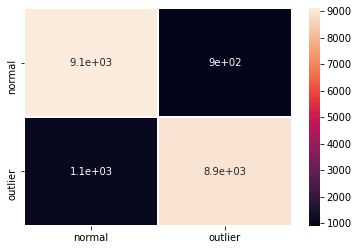

In [23]:
y_pred = od_preds['data']['is_outlier']
labels = ['normal', 'outlier']
f1 = f1_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
print('F1 score: {:.3f} -- Accuracy: {:.3f} -- Precision: {:.3f} '
      '-- Recall: {:.3f}'.format(f1, acc, prec, rec))
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True, cbar=True, linewidths=.5)
plt.show()

We can also plot the ROC curve based on the instance level outlier scores and compare it with the likelihood of only the semantic model:

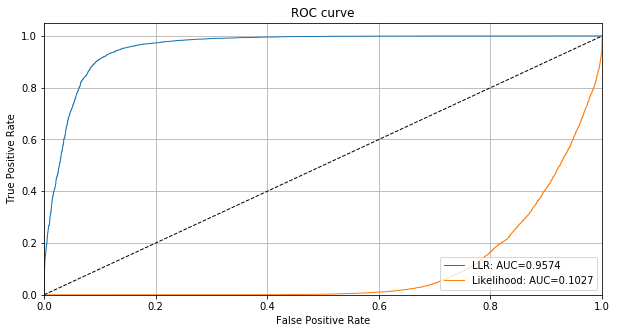

In [24]:
roc_data = {
    'LLR': {'scores': od_preds['data']['instance_score'], 'labels': y_test},
    'Likelihood': {'scores': -logp_s, 'labels': y_test}  # negative b/c outlier score
}
plot_roc(roc_data)

### Analyse feature scores

To understand why the likelihood ratio works to detect outliers but the raw log likelihoods don't, it is helpful to look at the pixel-wise log likelihoods of both the semantic and background models.

In [25]:
n_plot = 5

In [26]:
# semantic model
logp_fn_s = partial(od.dist_s.log_prob, return_per_feature=True)
logp_s_pixel_in = predict_batch(X_test_in[:n_plot], logp_fn_s, batch_size=32)
logp_s_pixel_ood = predict_batch(X_test_ood[:n_plot], logp_fn_s, batch_size=32)

# background model
logp_fn_b = partial(od.dist_b.log_prob, return_per_feature=True)
logp_b_pixel_in = predict_batch(X_test_in[:n_plot], logp_fn_b, batch_size=32)
logp_b_pixel_ood = predict_batch(X_test_ood[:n_plot], logp_fn_b, batch_size=32)

# pixel-wise likelihood ratios
llr_pixel_in = logp_s_pixel_in - logp_b_pixel_in
llr_pixel_ood = logp_s_pixel_ood - logp_b_pixel_ood

Plot in-distribution instances:

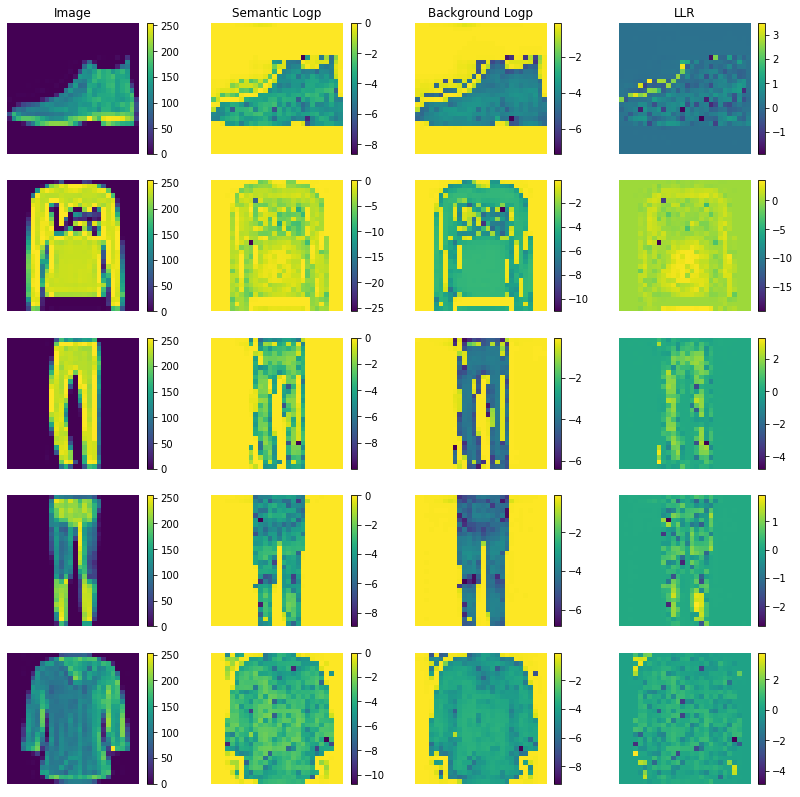

In [27]:
idx = list(np.arange(n_plot))
plot_grid_logp(idx, X_test_in, logp_s_pixel_in, logp_b_pixel_in, figsize=(14,14))

It is clear that both the semantic and background model attach high probabilities to the background pixels. This effect is cancelled out in the likelihood ratio in the last column. The same applies to the out-of-distribution instances:

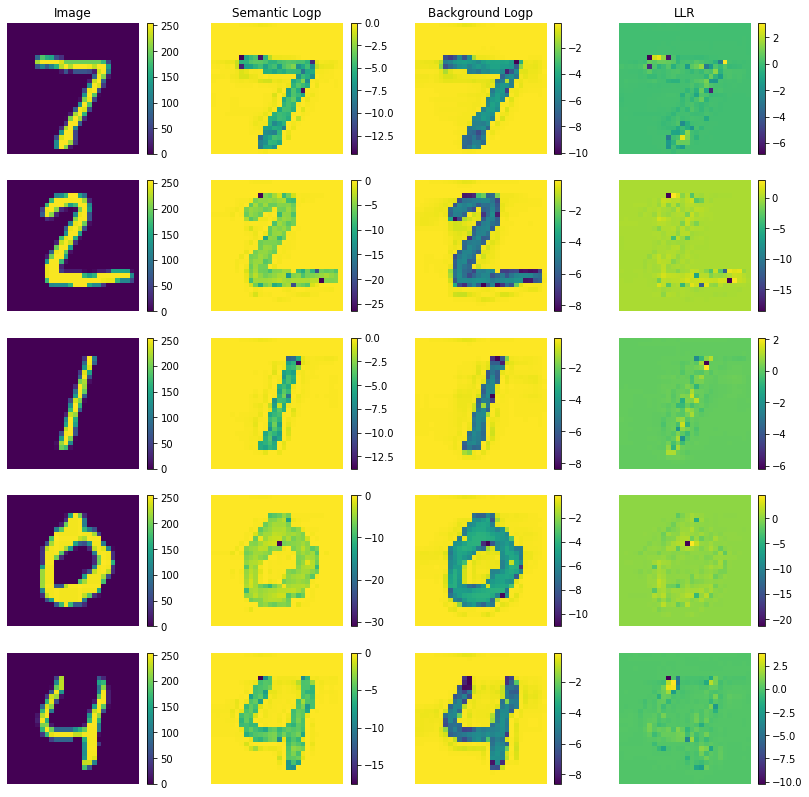

In [28]:
idx = list(np.arange(n_plot))
plot_grid_logp(idx, X_test_ood, logp_s_pixel_ood, logp_b_pixel_ood, figsize=(14,14))